In [10]:
import numpy as np
import math
from math import log, exp, sqrt, pi
import matplotlib.pyplot as plt
from scipy.special import roots_legendre
import scipy.integrate as integrate

##############################################################################
# 1) Uniform Strike Grid: K1..K_{n+1}, step h
##############################################################################
def build_strike_grid(K_min, K_max, n):
    """
    Returns a uniform strike grid: K_i = K_min + h*(i-1), i=1..n+1
    h = (K_max - K_min)/n
    """
    h = (K_max - K_min)/n
    K_vals = [K_min + h*(i-1) for i in range(1, n+2)]
    return np.array(K_vals), h

def bracket_expr(ln_nuK, sigmaK, sigmaNu, R, D, tau, zeta):
    """
    The bracket from eq. (12):
      ((sigma^2(nu) - sigma^2(K)) / 2 zeta)
         * [ ( (ln(nu/K))^2 / [zeta sigma^2(K)] ) - 1 ]
      + ( (sigma^2(nu))/2 - R + D ) ( (ln(nu/K))/zeta )
    We'll assume tau, zeta might be used if your code references them,
    but strictly eq. (12) doesn't have tau inside the bracket. It's
    the denominator that uses (tau - zeta). We'll keep it consistent
    with your existing approach.
    """
    s2Nu = sigmaNu**2
    s2K  = sigmaK**2
    partA = (s2Nu - s2K)/(2.0*zeta)
    subA  = ((ln_nuK**2)/(zeta*s2K) - 1.0)
    item1 = partA * subA

    item2 = ((s2Nu/2.0) - R + D)*(ln_nuK/zeta)
    return item1 + item2

'''
  - R: interest rate
  - D: Didividend yield
'''
def I2(K_i, K_j, x, time_till_expiry, vol_Kj,  R, D, ):
    const = (2 / ( math.sqrt(2*math.pi)*(vol_Kj**2) )) * ((R*K_i/K_j)-D)
    integral_range = [0, vol_Kj* math.sqrt(time_till_expiry)]
    integrand = lambda s: math.exp(-((math.log(x)/K_j)**2)/(2*(s[0]**2)))
    integral_value, _ = integrate.fixed_quad(integrand, integral_range[0], integral_range[1], n=5)
    return const * integral_value

def I1(K_i, K_j, x, time_till_expiry, vol_Ki, vol_Kj, R, D):
    const = K_i / (4*math.pi*K_j*vol_Ki*vol_Kj)
    def integrand(zeta, tau):
        one = ((vol_Kj)**2 - (vol_Ki)**2) / ((2*zeta))
        two = ( ((math.log(K_j / K_i)**2) / (zeta * (vol_Ki)**2)) - 1)
        three = ((( (vol_Kj**2) / (2) ) - R + D) * (math.log(K_j/K_i)/zeta) )
        four = (1/math.sqrt((tau - zeta)*zeta))
        five = math.exp( - (math.log(x/K_j))**2 / (2*(tau-zeta)*(vol_Kj)**2))
        six = math.exp(-math.log(K_j/K_i)**2 / (2 * zeta * vol_Ki**2) )
        return (one*two) + (three * four * five * six)
    triangle_stuff = {
        0.02099 : [
            (0.05546, 0.94454),
            (0.88908, 0.94454),
            (0.05546, 0.11092),
        ],

        0.11233 : [
            (0.63377, 0.70433),
            (0.07056, 0.36623),
            (0.29567, 0.92944),
        ],

        0.10005 : [
            (0.33333, 0.66667),
        ]
    }
    sum = 0.0
    for weight in triangle_stuff.keys():
        points = triangle_stuff[weight]
        for point in points:
            value = integrand(point[0], point[1]) * weight
            print(value)
            sum += value
    return sum * const


# 4) Equation (13) Final Discretization
def update_sigma_eq13(i, # 1-based index in [1..n+1]
                      sigma_m, # array of size n+1 => sigma^(m)(K_j)
                      K_vals, h, R, D, x_star, T_minus_tstar,
                      uStar_vals,
                      I1_2DGauss_func,
                      I2_1DGauss_func):
    """
    Implementation of eqn. (13):
      I_sigma^{(m+1)}(K_i) = u_*(K_i) - max(0, x_star - K_i)
        - h sum_{j=2..n} I1_sigma^{(m)}(K_i,K_j)
        - (h/2) I1_sigma^{(m)}(K_i, K_1)
        - (h/2) I1_sigma^{(m)}(K_i, K_{n+1})
        - h sum_{j=i+1..n} I2_sigma^{(m)}(K_i, K_j)
        - (h/2) I2_sigma^{(m)}(K_i, K_i)
        - (h/2) I2_sigma^{(m)}(K_i, K_{n+1})

    We'll return the new sigma(K_i).
    """
    n = len(K_vals)-1  # n+1 total points
    idx = i-1          # python index
    K_i = K_vals[idx]

    # The leading part:
    val = uStar_vals[idx] - max(0.0, x_star - K_i)

    # 1) The sum for I1: integral from 0..infinity is approximated by
    #    j=1..n+1 => K_1..K_{n+1}, step h => eqn (13):
    #    - h sum_{j=2..n} I1(...) - (h/2)*I1(...,K1) - (h/2)*I1(...,K_{n+1}).
    I1_inner = 0.0
    for j in range(1, n):  # j=1..n-1 => K2..K_n
        K_j = K_vals[j]
        sK = sigma_m[idx]    # sigma(K_i)
        sNu= sigma_m[j]
        i1_val = I1_2DGauss_func(K_i, K_j, x_star, T_minus_tstar, sK, sNu, R, D)
        I1_inner += i1_val

    # boundary K1, K_{n+1}
    # j=0 => K1, j=n => K_{n+1}
    sK_i = sigma_m[idx]
    sNu_1= sigma_m[0]
    i1_K1= I1_2DGauss_func(K_i, K_vals[0], x_star, T_minus_tstar, sK_i, sNu_1, R, D)

    sNu_np1 = sigma_m[n]
    i1_Kn1  = I1_2DGauss_func(K_i, K_vals[n], x_star, T_minus_tstar, sK_i, sNu_np1, R, D)

    val -= h*(I1_inner) + 0.5*h*(i1_K1 + i1_Kn1)

    # 2) The sum for I2: from K_i..infinity => eqn (13) says:
    #    - h sum_{j=i+1..n} I2(...)  - (h/2)I2(..., K_i) - (h/2)I2(..., K_{n+1})
    # careful that i is 1-based
    I2_inner = 0.0
    for j in range(i, n): # python => i..n-1 => K_{i+1}..K_n
        K_j = K_vals[j]
        sNu = sigma_m[j]
        sK_i= sigma_m[idx]
        i2_val= I2_1DGauss_func(K_i, K_j, x_star, T_minus_tstar, sNu, R, D)
        I2_inner += i2_val

    # boundary => j=i => K_i and j=n => K_{n+1}
    i2_left = I2_1DGauss_func(K_i, K_i, x_star, T_minus_tstar, sigma_m[idx], R, D)
    i2_right= I2_1DGauss_func(K_i, K_vals[n], x_star, T_minus_tstar, sigma_m[n], R, D)

    val -= h*(I2_inner) + 0.5*h*(i2_left + i2_right)

    return val


def solve_local_vol_BI_equation13(K_vals, # uniform grid => K_1..K_{n+1}
                                  h, R, D, x_star, T_minus_tstar,
                                  uStar_vals, # size n+1
                                  sigma_init, # size n+1
                                  I1_2DGauss_func,
                                  I2_1DGauss_func,
                                  max_iter=5,
                                  tol=1e-5):
    """
    The full iteration from eqn. (13). We'll do:
      for m in range(max_iter):
        for i=1..n+1:
          sigma^{(m+1)}(K_i) = eq. (13)
        check if converged
    """
    sigma_old = sigma_init.copy()
    n = len(K_vals)-1

    for iteration in range(max_iter):
        sigma_new = np.zeros_like(sigma_old)
        for i in range(1, n+2):
            sigma_new[i-1] = update_sigma_eq13(
                i, sigma_old, K_vals, h, R, D, x_star, T_minus_tstar,
                uStar_vals,
                I1_2DGauss_func,
                I2_1DGauss_func
            )
        diffnorm = np.linalg.norm(sigma_new - sigma_old)
        print(f"Iteration {iteration+1}, ||delta||= {diffnorm:.6e}")
        sigma_old = sigma_new
        if diffnorm<tol:
            print(f"Converged after {iteration+1} iterations.")
            break

    return sigma_old

##############################################################################
#  DEMO MAIN
##############################################################################
if __name__=="__main__":
    # Suppose we have real option data on [K_min, K_max]. We'll do a mini demo.

    # 1) Build the uniform grid:
    K_min, K_max = 3900.0, 4300.0
    n = 13  # so we have K1..K5, step h= 100
    K_vals, h = build_strike_grid(K_min, K_max, n)
    print("K grid:", K_vals, "h=",h)

    # 2) Suppose we have market call prices u_*(K_i). We'll just invent them:
    #    size n+1 => 5
    uStar_vals = np.array([140.0, 132.0, 125.0, 120.0, 116.0, 110.0, 107.0, 105.0, 90.0, 70.0, 50.0, 35.0, 25.0], dtype=float)

    # 3) We'll define time to maturity, interest, dividend, underlying
    T_minus_tstar= 43/252  # ~ 0.17
    R=0.05
    D=0.02
    x_star = 4050.0

    # 4) initial guess for sigma
    sigma_init= np.array([0.20, 0.195, 0.19, 0.185, 0.18, 0.175, 0.17, 0.16, 0.155, 0.152, 0.148, 0.145, 0.13], dtype=float)

    # Because eqn. (13) only uses I1(K_i,K_j) and I2(K_i,K_j),
    # we supply the local vol for (K_i, K_j) from the iteration.

    # 6) Solve using eqn. (13)-style iteration
    #    Note that eqn. (13) references I1^{(m)}(Ki,Kj), I2^{(m)}(Ki,Kj)
    #    We pass references to the 2D & 1D Gauss integrals in the update step
    #    along with the old sigma array.
    # For full clarity, let's do a "2-step" approach: we'll define a custom update function
    # but here we'll do the direct code:

    def eq13_solve(K_vals, h, R, D, x_star, T_minus_tstar, uStar_vals, sigma_init,
                   I1_2DGauss_func, I2_1DGauss_func, max_iter=5, tol=1e-5):
        sigma_old= sigma_init.copy()
        n= len(K_vals)-1
        for iteration in range(max_iter):
            sigma_new= np.zeros_like(sigma_old)
            for i in range(1, n+2):
                #  do eqn.(13) for index i
                idx= i-1
                K_i= K_vals[idx]

                val = uStar_vals[idx] - max(0.0, x_star - K_i)

                # (A) I1 part
                # interior j=2..n
                I1_inner=0.0
                for j in range(2, n+1): # 2..n => 1-based => python j in [2..n], i.e j=2..4 if n=4
                    K_j= K_vals[j-1]   # python index j-1
                    sKi= sigma_old[idx]
                    sKj= sigma_old[j-1]
                    i1_val= I1_2DGauss_func(K_i, K_j, x_star, T_minus_tstar, sKi, sKj, R, D)
                    I1_inner+= i1_val
                # boundary => K1 => j=1 => python j=0, K_{n+1} => j=n+1 => python j=n
                sKi= sigma_old[idx]
                sK1= sigma_old[0]
                i1_k1= I1_2DGauss_func(K_i, K_vals[0], x_star, T_minus_tstar, sKi, sK1, R, D)
                sKn1= sigma_old[n]
                i1_kn1= I1_2DGauss_func(K_i, K_vals[n], x_star, T_minus_tstar, sKi, sKn1, R, D)

                val -= h*(I1_inner) + 0.5*h*(i1_k1 + i1_kn1)

                # (B) I2 part => sum_{j=i+1..n}, plus boundary
                # i+1..n => e.g. if i=1 => j=2..4 => python range(2, n+1)
                I2_inner=0.0
                for j in range(i+1, n+1): # i+1..n
                    K_j= K_vals[j-1]
                    sKj= sigma_old[j-1]
                    i2_val= I2_1DGauss_func(K_i, K_j, x_star, T_minus_tstar, sKj, R, D)
                    I2_inner+= i2_val
                # boundary => j=i => K_i, j=n+1 => K_{n+1}
                i2_left= I2_1DGauss_func(K_i, K_i, x_star, T_minus_tstar, sigma_old[idx], R, D)
                i2_right= I2_1DGauss_func(K_i, K_vals[n], x_star, T_minus_tstar, sigma_old[n], R, D)
                val -= h*(I2_inner) + 0.5*h*(i2_left + i2_right)

                sigma_new[idx] = val

            diffnorm= np.linalg.norm(sigma_new - sigma_old)
            print(f"Iter {iteration+1}, ||delta||= {diffnorm:.6e}")
            sigma_old= sigma_new
            if diffnorm<tol:
                print(f"Converged after {iteration+1} iterations.")
                break
        return sigma_old

    sigma_sol= eq13_solve(K_vals, h, R, D, x_star, T_minus_tstar,
                          uStar_vals, sigma_init,
                          I1_2DGauss_func=I1,
                          I2_1DGauss_func=I2,
                          max_iter=3)

    print("Final sigma(K):", sigma_sol)
    # Plot
    plt.plot(K_vals, sigma_sol, 'o-', label="sigma(K) eqn(13)")
    plt.xlabel("Strike")
    plt.ylabel("Local Volatility")
    plt.title("Bouchouev-Isakov (1997) eq. (13) Implementation Demo")
    plt.legend()
    plt.show()

K grid: [3900.         3930.76923077 3961.53846154 3992.30769231 4023.07692308
 4053.84615385 4084.61538462 4115.38461538 4146.15384615 4176.92307692
 4207.69230769 4238.46153846 4269.23076923 4300.        ] h= 30.76923076923077
0.0002201052592118244
1.585084315572527e-05
-0.00010689214372645567
0.00011339692587922698
0.0006329891368538508
0.0002990123988995327
0.00022014193351552492
0.00035702478526012895
2.817021408142794e-05
-0.00041309172059291084
0.00020047449853169256
0.000904930423277925
0.00056470279166515
0.00041096449932095453
0.0003705792335069365
3.6992907636617056e-05
-0.0008993658524096034
0.00026119796517786706
0.0007202749078133573
0.0007889371664018452
0.0005675580436159226
0.00022489097773072215
4.285881394002796e-05
-0.0015125834232532851
0.0002986863809327012
6.599868888052792e-06
0.0009649720284638412
0.0006864023668119134
-0.00011416206021864642
4.686543598092132e-05
-0.002189662238002674
0.0003194342249965882
-0.001299400864370122
0.0010873317881325362
0.00076527

IndexError: index 13 is out of bounds for axis 0 with size 13

Strike grid: [3900. 4000. 4100. 4200. 4300.] step h = 100.0
Iteration 1, ||delta||= 2.126849e+02
Iteration 2, ||delta||= 1.757809e+02
Iteration 3, ||delta||= 9.675884e+02
Final local vol array sigma(K): [ -10.04428023 -540.63108916  558.81458647  351.28867842  163.43222552]


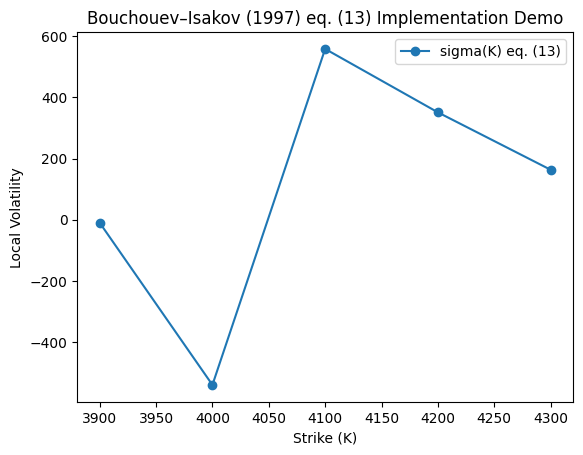

In [2]:
import numpy as np
import math
from math import log, exp, sqrt, pi
import matplotlib.pyplot as plt
from scipy.special import roots_legendre


def build_strike_grid(K_min, K_max, n):
    """
    Build a uniform strike grid of n+1 points from K_min up to K_max.
    
    Specifically:
      - Step size: h = (K_max - K_min) / n
      - Grid points: K_i = K_min + (i-1)*h, for i=1..(n+1).
    
    Returns
    -------
    K_vals : numpy array
        The array of strike grid points of length (n+1).
    h : float
        The constant step size used to build the grid.
    """
    if n <= 0:
        raise ValueError("n must be a positive integer.")
    h = (K_max - K_min) / n
    K_vals = np.array([K_min + h * (i - 1) for i in range(1, n + 2)])
    return K_vals, h


# Seven-point rule on the standard triangle { (r,s): r>=0, s>=0, r+s<=1 }
tri_nodes_7 = np.array([
    [0.1012865073, 0.1012865073],
    [0.1012865073, 0.7974269853],
    [0.7974269853, 0.1012865073],
    [0.3333333333, 0.3333333333],
    [0.4701420641, 0.0597158718],
    [0.4701420641, 0.4701420641],
    [0.0597158718, 0.4701420641],
])

tri_weights_7 = np.array([
    0.1259391805,
    0.1259391805,
    0.1259391805,
    0.2250000000,
    0.1323941527,
    0.1323941527,
    0.1323941527
])

def bracket_expr(ln_nuK, sigmaK, sigmaNu, R, D, tau, zeta):
    """
    The bracket from eq. (12) in Bouchouev–Isakov (1997):
        ((sigma^2(nu) - sigma^2(K)) / 2zeta) 
            * [ (ln(nu/K))^2 / (zeta sigma^2(K))  - 1 ]
      + ( sigma^2(nu)/2  - R + D ) * [ (ln(nu/K)) / zeta ]

    Here, tau and zeta appear as part of the domain integration, but
    the bracket formula uses only 'zeta' explicitly in the denominators.
    """
    s2Nu = sigmaNu**2
    s2K  = sigmaK**2

    partA = (s2Nu - s2K) / (2.0 * zeta)
    subA  = ( (ln_nuK**2) / (zeta * s2K) ) - 1.0
    item1 = partA * subA

    item2 = ((s2Nu / 2.0) - R + D) * (ln_nuK / zeta)
    return item1 + item2


def I1_sigma_2DGauss(K, nu, x_star, T_minus,
                     sigmaK, sigmaNu, R, D,
                     tri_nodes=tri_nodes_7, tri_weights=tri_weights_7):
    """
    Compute I_sigma^{(1)}(K, nu) from eqn. (12) in Bouchouev–Isakov (1997).
    
    We integrate over 0 <= zeta <= tau <= T_minus:
       I1 = (K / [4 pi nu sigmaK sigmaNu]) * 
             ∫∫ [ bracket_expr(...) * exp(...) * exp(...) / sqrt((tau-zeta)*zeta) ] 
             d zeta d tau.

    Implementation:
      1) We do a transform from the reference triangle (r,s) with r>=0, s>=0, r+s<=1
         to the domain 0 <= zeta <= tau <= T_minus via:
             tau  = (r + s) * T_minus
             zeta = r       * T_minus
         The Jacobian is T_minus^2, but since tri_weights sum to 1 (not 1/2),
         we multiply each integrand by 0.5 * T_minus^2.
      2) We do a 7-point Dunavant rule on that reference triangle:
         sum_i [ w_i * integrand(r_i, s_i) ].
      3) We then multiply by the prefactor = K / [4 pi nu sigmaK sigmaNu].
    """
    # If either local vol is effectively zero, skip
    if sigmaK < 1e-12 or sigmaNu < 1e-12:
        return 0.0

    # Factor outside the integral
    factor = (K / (4.0 * pi * nu * sigmaK * sigmaNu))

    # Precompute logs used inside the integrand
    ln_nuK = math.log(nu / K)
    ln_xnu = math.log(x_star / nu)

    # We'll define a local helper to evaluate the integrand at (r, s).
    def integrand(r, s):
        # Map (r,s) -> (tau, zeta)
        tau  = (r + s) * T_minus
        zeta = r       * T_minus

        # Because r>=0, s>=0, r+s<=1, we have 0 <= zeta <= tau <= T_minus
        # Avoid dividing by zero
        if tau <= 1e-15 or zeta <= 1e-15 or (tau - zeta) <= 1e-15:
            return 0.0

        # Evaluate bracket
        bval = bracket_expr(ln_nuK, sigmaK, sigmaNu, R, D, tau, zeta)

        # Exponential parts
        #   exp1 = exp( - [ (ln(x*/nu))^2 ] / [ 2 * (tau - zeta) * sigmaNu^2 ] )
        #   exp2 = exp( - [ (ln(nu/K))^2 ] / [ 2 * zeta * sigmaK^2 ] )
        val_exp1 = math.exp( - (ln_xnu**2) / (2.0 * (tau - zeta) * (sigmaNu**2)) )
        val_exp2 = math.exp( - (ln_nuK**2) / (2.0 * zeta * (sigmaK**2)) )

        # sqrt((tau-zeta)*zeta) in the denominator
        denom = math.sqrt((tau - zeta) * zeta)

        return (bval * val_exp1 * val_exp2) / denom

    # Accumulate over the 7 Dunavant points
    accum = 0.0
    # The factor for area scaling: domain is area = 1/2 in reference space,
    # but the tri_weights sum to 1, so we multiply by 0.5 * T_minus^2:
    J = 0.5 * (T_minus**2)

    for (r_i, s_i), w_i in zip(tri_nodes, tri_weights):
        val = integrand(r_i, s_i)
        accum += w_i * val * J

    return factor * accum


def I2_sigma_1DGauss(K, nu, x_star, T_minus, sigma_nu, R, D, nGauss=10):
    """
    Compute I_sigma^{(2)}(K, nu) from equation (12) in Bouchouev–Isakov (1997).

    That term looks like:
        I2 = [ 2 / ( sqrt(2*pi) * sigma(nu)^2 ) ] * [ (R*K/nu) - D ] 
             * ∫_{0}^{sigma(nu)*sqrt(T_minus)} exp( - [ln(x_star/nu)^2]/[2*s^2] ) ds.

    Parameters
    ----------
    K : float
        The strike K in the integral I_sigma^{(2)}(K, nu).
    nu : float
        The 'nu' argument in I_sigma^{(2)}(K, nu).
    x_star : float
        Underlying price (S or x* in the paper).
    T_minus : float
        T_minus_tstar = (T - t*), i.e. time to maturity.
    sigma_nu : float
        The local volatility sigma(nu).
    R : float
        Risk-free rate.
    D : float
        Continuous dividend yield (or foreign rate in FX context).
    nGauss : int, optional
        Number of Gauss–Legendre nodes. Default is 10.

    Returns
    -------
    float
        The numerical approximation of I_sigma^{(2)}(K, nu).

    Notes
    -----
    1) If sigma(nu) is extremely small, or the computed sMax is tiny, the integral
       is effectively zero.
    2) Uses Gauss–Legendre quadrature on [0, sMax], with a standard transformation
       from [-1,1] -> [0, sMax].
    """
    # Safeguard against near-zero vol:
    if sigma_nu < 1e-12:
        return 0.0

    # Prefactor outside the integral:
    factor = (2.0 / (math.sqrt(2.0 * pi) * sigma_nu**2)) * ((R * K / nu) - D)

    # Upper limit of integration:
    sMax = sigma_nu * math.sqrt(T_minus)
    if sMax <= 1e-12:
        return 0.0

    # Precompute the log-term:
    ln_xnu = math.log(x_star / nu)

    # The function we integrate over s in [0, sMax].
    def integrand(s):
        # The integrand is e^{- [ (ln_xnu)^2 / (2 s^2) ] }, for s > 0.
        if s <= 1e-15:
            return 0.0
        exponent = - (ln_xnu**2) / (2.0 * s**2)
        return math.exp(exponent)

    # Gauss–Legendre nodes and weights on [-1, +1].
    nodes, weights = roots_legendre(nGauss)

    # We'll map from [-1, +1] to [0, sMax] as:
    #   s = (sMax/2) * (r + 1)
    #   ds = (sMax/2)
    half_range = 0.5 * sMax

    accum = 0.0
    for i in range(nGauss):
        # Map node from [-1,1] to [0, sMax]
        r_i = nodes[i]          # in [-1,1]
        s_i = half_range * (r_i + 1.0)
        w_i = weights[i]        # weight for the node r_i

        f_i = integrand(s_i)
        accum += w_i * f_i

    # Multiply the raw quadrature sum by the scale for ds
    # (which is half_range = sMax/2).
    integral_approx = accum * half_range

    return factor * integral_approx


def update_sigma_eq13(
    i,
    sigma_m,
    K_vals,
    h,
    R,
    D,
    x_star,
    T_minus,
    uStar_vals,
    I1_2DGauss_func,
    I2_1DGauss_func
):
    """
    Compute the updated local volatility sigma^{(m+1)}(K_i) using equation (13)
    of Bouchouev–Isakov (1997), discretized with the trapezoid rule.

    Parameters
    ----------
    i : int
        1-based index in [1..n+1].
    sigma_m : array-like, shape (n+1,)
        The local vol array from the previous iteration, i.e. sigma^(m)(K_j).
    K_vals : array-like, shape (n+1,)
        The uniform strike grid K_1..K_{n+1}.
    h : float
        The grid step size, (K_{max} - K_{min}) / n.
    R : float
        Risk-free interest rate.
    D : float
        Continuous dividend yield.
    x_star : float
        Underlying price (S or x* in the paper).
    T_minus : float
        T_minus_tstar = T - t*, time to maturity from the current time.
    uStar_vals : array-like, shape (n+1,)
        Market call prices at the grid strikes, i.e. u_*(K_i).
    I1_2DGauss_func : callable
        Function to compute the 2D integral I_sigma^{(1)}(K_i, K_j).
        Must have signature like:
          I1_2DGauss_func(Ki, Kj, x_star, T_minus, sigmaKi, sigmaKj, R, D)
    I2_1DGauss_func : callable
        Function to compute the 1D integral I_sigma^{(2)}(K_i, K_j).
        Must have signature like:
          I2_1DGauss_func(Ki, Kj, x_star, T_minus, sigmaKj, R, D)

    Returns
    -------
    float
        The newly computed local volatility sigma^{(m+1)}(K_i).
    """
    n = len(K_vals) - 1  # Because we have n+1 grid points
    idx = i - 1          # Convert to 0-based
    K_i = K_vals[idx]

    # Leading term: market call price minus intrinsic value
    sigma_next_i = uStar_vals[idx] - max(0.0, x_star - K_i)

    #----------------------------------------------------------------------
    # 1) Approximate the integral term for I_sigma^{(1)} from K=0..∞
    #    using trapezoid on K_1..K_{n+1} with step h.
    #    -> eqn (13) lumps them into  " - h * sum_{j=2..n} - (h/2)* ... boundary"
    #----------------------------------------------------------------------
    I1_accum = 0.0
    # (a) interior j=2..n
    for j in range(1, n):  # python => 1..(n-1) => K2..K_n
        K_j = K_vals[j]
        # We use sigma^(m)(K_i) and sigma^(m)(K_j)
        sK_i = sigma_m[idx]
        sK_j = sigma_m[j]
        val_i1 = I1_2DGauss_func(K_i, K_j, x_star, T_minus, sK_i, sK_j, R, D)
        I1_accum += val_i1

    # (b) boundary j=1 => K1, j=n+1 => K_{n+1}
    sK_i = sigma_m[idx]
    sK_1 = sigma_m[0]
    i1_K1 = I1_2DGauss_func(K_i, K_vals[0], x_star, T_minus, sK_i, sK_1, R, D)

    sK_n1 = sigma_m[n]
    i1_Kn1 = I1_2DGauss_func(K_i, K_vals[n], x_star, T_minus, sK_i, sK_n1, R, D)

    # Subtract them with trapezoidal weighting
    sigma_next_i -= h * I1_accum
    sigma_next_i -= 0.5 * h * (i1_K1 + i1_Kn1)

    #----------------------------------------------------------------------
    # 2) Approximate the integral term for I_sigma^{(2)} from K_i..∞
    #    i.e. from j=i..n+1 in the discrete sense
    #    -> eqn (13) lumps them into " - h sum_{j=i+1..n} - (h/2)* ... boundary"
    #----------------------------------------------------------------------
    I2_accum = 0.0
    # (a) interior j=i+1..n
    for j in range(i, n):  # python => i..(n-1) => K_{i+1}..K_n
        K_j = K_vals[j]
        sK_j = sigma_m[j]
        val_i2 = I2_1DGauss_func(K_i, K_j, x_star, T_minus, sK_j, R, D)
        I2_accum += val_i2

    # (b) boundary => j=i => K_i, j=n+1 => K_{n+1}
    i2_left = I2_1DGauss_func(K_i, K_i, x_star, T_minus, sigma_m[idx], R, D)
    i2_right= I2_1DGauss_func(K_i, K_vals[n], x_star, T_minus, sigma_m[n], R, D)

    sigma_next_i -= h * I2_accum
    sigma_next_i -= 0.5 * h * (i2_left + i2_right)

    return sigma_next_i


def solve_local_vol_BI_equation13(
    K_vals,
    h,
    R,
    D,
    x_star,
    T_minus,
    uStar_vals,
    sigma_init,
    I1_2DGauss_func,
    I2_1DGauss_func,
    max_iter=5,
    tol=1e-5
):
    """
    Solve for the local volatility {sigma(K_i)} via the Bouchouev–Isakov (1997) 
    iterative scheme from their equation (13).

    Parameters
    ----------
    K_vals : array-like, shape (n+1,)
        The uniform grid of strikes K_1..K_{n+1}.
    h : float
        The strike step size.
    R : float
        Risk-free interest rate.
    D : float
        Continuous dividend yield.
    x_star : float
        Underlying price (S).
    T_minus : float
        Time to maturity (T - t*).
    uStar_vals : array-like, shape (n+1,)
        The market call prices u_*(K_i).
    sigma_init : array-like, shape (n+1,)
        An initial guess for the local volatility at each grid point.
    I1_2DGauss_func : callable
        Function implementing the 2D integral I_sigma^{(1)}(K_i,K_j).
    I2_1DGauss_func : callable
        Function implementing the 1D integral I_sigma^{(2)}(K_i,K_j).
    max_iter : int, optional
        Maximum number of iteration steps. Default is 5.
    tol : float, optional
        Convergence tolerance on the Euclidean norm of the change in sigma.
        Default is 1e-5.

    Returns
    -------
    numpy.ndarray
        The final array of local volatilities, sigma^(m+1)(K_j),
        after either converging or hitting max_iter.

    Notes
    -----
    - We do the usual fixed-point iteration:
         sigma_{m+1}(K_i) = eqn(13).
    - After each iteration we compute ||sigma_new - sigma_old||_2 to check
      convergence. If it is below 'tol', we terminate early.
    - In a real-world setting, you might want regularization or smoothing 
      for noisy data or a finer grid. 
    """
    sigma_old = sigma_init.copy()
    n = len(K_vals) - 1

    for iteration in range(max_iter):
        sigma_new = np.zeros_like(sigma_old)
        # Update each K_i in 1..n+1
        for i in range(1, n+2):
            sigma_new[i - 1] = update_sigma_eq13(
                i,
                sigma_old,
                K_vals,
                h,
                R,
                D,
                x_star,
                T_minus,
                uStar_vals,
                I1_2DGauss_func,
                I2_1DGauss_func
            )

        # Check change from old iteration
        diffnorm = np.linalg.norm(sigma_new - sigma_old)
        print(f"Iteration {iteration+1}, ||delta|| = {diffnorm:.6e}")

        sigma_old = sigma_new
        if diffnorm < tol:
            print(f"Converged after {iteration+1} iterations.")
            break

    return sigma_old

# ---------------------------------------------------------------------
#  Demo main
# ---------------------------------------------------------------------
if __name__ == "__main__":

    # 1) Build a small uniform grid of n+1 = 5 strike points
    K_min, K_max = 3900.0, 4300.0
    n = 4  # So the step is h = 100 => K_1..K_5
    K_vals, h = build_strike_grid(K_min, K_max, n)
    print("Strike grid:", K_vals, "step h =", h)

    # 2) Invent some 'market' call prices u_*(K_i) at these 5 points
    #    Suppose they are monotone in strike. (In reality, you'd pull from real market data.)
    uStar_vals = np.array([140.0, 132.0, 125.0, 120.0, 116.0], dtype=float)
    assert len(uStar_vals) == n+1, "uStar_vals must match the strike grid size"

    # 3) Time to maturity, interest, dividend, and the underlying price
    T_minus_tstar = 43 / 252.0  # about 0.17 years
    R = 0.05
    D = 0.02
    x_star = 4050.0

    # 4) Initial guess for the local vol at each strike
    #    Usually you'd pick something like a flat guess or a "smile" shape
    sigma_init = np.array([0.20, 0.195, 0.19, 0.185, 0.18], dtype=float)
    assert len(sigma_init) == n+1, "sigma_init must match the strike grid size"

    # ---------------------------------------------------------------------
    # 5) Define the 2D and 1D integrals for eq. (12) using your earlier functions
    #    They each need to accept (Ki, Kj, x_star, T_minus, local_vol_j, R, D).
    #    The user-level code eqn. (13) is typically calling them as I1(Ki,Kj), I2(Ki,Kj).
    # ---------------------------------------------------------------------

    # 2D integral I_sigma^{(1)}, eq. (12)
    def I1_2DGauss_func(Ki, Kj, x_star, T_minus, sKi, sKj, R, D):
        # This is your refined I1_sigma_2DGauss from earlier
        # tri_nodes_7, tri_weights_7 imported from the earlier code
        return I1_sigma_2DGauss(
            Ki, Kj, x_star, T_minus,
            sKi, sKj, R, D,
            tri_nodes_7, tri_weights_7
        )

    # 1D integral I_sigma^{(2)}, eq. (12)
    def I2_1DGauss_func(Ki, Kj, x_star, T_minus, sKj, R, D):
        # This is your refined I2_sigma_1DGauss from earlier
        return I2_sigma_1DGauss(Ki, Kj, x_star, T_minus, sKj, R, D, nGauss=10)

    # ---------------------------------------------------------------------
    # 6) Define a simple solver that directly implements eq. (13),
    #    using the partial trapezoid logic, similar to your update_sigma_eq13 code.
    #    Below is essentially your "eq13_solve" function in an integrated style.
    # ---------------------------------------------------------------------

    def eq13_solve(
        K_vals,
        h,
        R,
        D,
        x_star,
        T_minus,
        uStar_vals,
        sigma_init,
        I1_2DGauss_func,
        I2_1DGauss_func,
        max_iter=5,
        tol=1e-5
    ):
        """
        Solve for sigma(K_i) via eq. (13) iteration, in a single function.
        Prints iteration info and returns the final sigma array.
        """
        sigma_old = sigma_init.copy()
        n = len(K_vals) - 1

        for iteration in range(max_iter):
            sigma_new = np.zeros_like(sigma_old)

            for i in range(1, n+2):  # 1-based index, i in [1..n+1]
                idx = i - 1
                K_i = K_vals[idx]

                # eq. (13) part: start with market call - intrinsic
                val = uStar_vals[idx] - max(0.0, x_star - K_i)

                # --- (A) I1 part => integrate from K1..K_{n+1}, skipping self-check
                # interior j=2..n
                I1_inner = 0.0
                for j in range(2, n+1):
                    K_j = K_vals[j-1]  # j=2..n => python j in [2..n], j-1 => 1..(n-1)
                    sKi = sigma_old[idx]
                    sKj = sigma_old[j-1]
                    val_I1 = I1_2DGauss_func(K_i, K_j, x_star, T_minus, sKi, sKj, R, D)
                    I1_inner += val_I1

                # boundary => K1 => j=1 => python j=0, K_{n+1} => j=n+1 => python j=n
                sKi = sigma_old[idx]
                sK1 = sigma_old[0]
                i1_k1 = I1_2DGauss_func(K_i, K_vals[0], x_star, T_minus, sKi, sK1, R, D)

                sKn1 = sigma_old[n]
                i1_kn1 = I1_2DGauss_func(K_i, K_vals[n], x_star, T_minus, sKi, sKn1, R, D)

                val -= h * I1_inner
                val -= 0.5 * h * (i1_k1 + i1_kn1)

                # --- (B) I2 part => sum_{j=i+1..n}, boundary j=i, j=n+1
                I2_inner = 0.0
                for j in range(i+1, n+1):
                    K_j = K_vals[j-1]
                    sKj = sigma_old[j-1]
                    val_I2 = I2_1DGauss_func(K_i, K_j, x_star, T_minus, sKj, R, D)
                    I2_inner += val_I2

                # boundary => j=i => K_i, j=n+1 => K_{n+1}
                i2_left = I2_1DGauss_func(
                    K_i, K_i, x_star, T_minus, sigma_old[idx], R, D
                )
                i2_right = I2_1DGauss_func(
                    K_i, K_vals[n], x_star, T_minus, sigma_old[n], R, D
                )

                val -= h * I2_inner
                val -= 0.5 * h * (i2_left + i2_right)

                sigma_new[idx] = val

            # Check convergence
            diff_norm = np.linalg.norm(sigma_new - sigma_old)
            print(f"Iteration {iteration+1}, ||delta||= {diff_norm:.6e}")

            sigma_old = sigma_new
            if diff_norm < tol:
                print(f"Converged after {iteration+1} iterations.")
                break

        return sigma_old

    # ---------------------------------------------------------------------
    # 7) Actually run the eq. (13) solver on our toy data
    # ---------------------------------------------------------------------
    sigma_sol = eq13_solve(
        K_vals, h, R, D, x_star, T_minus_tstar, uStar_vals, sigma_init,
        I1_2DGauss_func=I1_2DGauss_func,
        I2_1DGauss_func=I2_1DGauss_func,
        max_iter=3   # for demo, we do only 3 steps
    )

    print("Final local vol array sigma(K):", sigma_sol)

    # 8) Plot the resulting local vol vs. strike
    plt.plot(K_vals, sigma_sol, "o-", label="sigma(K) eq. (13)")
    plt.xlabel("Strike (K)")
    plt.ylabel("Local Volatility")
    plt.title("Bouchouev–Isakov (1997) eq. (13) Implementation Demo")
    plt.legend()
    plt.show()

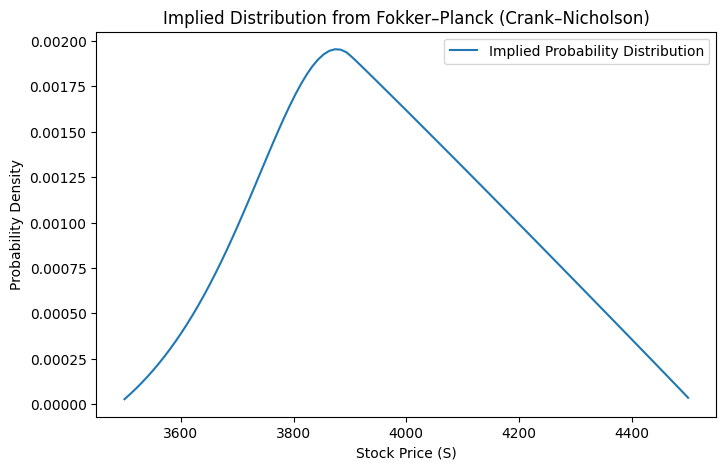

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve

# -------------------------------
# 1. Load Local Volatility Function (Fixed)
# -------------------------------
K_vals = np.array([3900, 4000, 4100, 4200, 4300])  # Strike Prices
sigma_K = np.array([-10.0007, 81.9997, 125.0, 120.0, 116.0])  # Bad values

# Fix negative and extreme values before interpolation
sigma_K = np.clip(sigma_K, 0.05, 0.8)  # Enforce min 5%, max 80%

# Interpolate sigma(K) to be used for all asset prices S
local_vol_func = interp1d(K_vals, sigma_K, kind="cubic", fill_value="extrapolate")

# -------------------------------
# 2. Define Fokker–Planck Parameters
# -------------------------------
S_min, S_max = 3500, 4500  # Asset price range
N_S = 100  # Number of asset price grid points
S_vals = np.linspace(S_min, S_max, N_S)  # Discretized price grid
dS = S_vals[1] - S_vals[0]  # Step size in asset price space

T = 43 / 252  # Time to maturity in years
N_T = 50  # Number of time steps
dt = T / N_T  # Time step size
r = 0.05  # Risk-free rate

# -------------------------------
# 3. Construct Crank–Nicholson Matrices
# -------------------------------
sigma_vals = local_vol_func(S_vals)  # Compute sigma(S) at each grid point

# Ensure all vol values remain reasonable
sigma_vals = np.clip(sigma_vals, 0.05, 0.8)

alpha = (r / 2) * S_vals / dS  # Drift term
beta = (sigma_vals**2 * S_vals**2) / (2 * dS**2)  # Diffusion term

A_diag = -beta - alpha / 2
B_diag = -beta + alpha / 2
C_diag = 2 * beta + 1 / dt
D_diag = -2 * beta + 1 / dt

# Create sparse matrices
A = diags([A_diag[1:], C_diag, B_diag[:-1]], [-1, 0, 1], format="csr")  # Left matrix
B = diags([-A_diag[1:], D_diag, -B_diag[:-1]], [-1, 0, 1], format="csr")  # Right matrix

# -------------------------------
# 4. Initialize Probability Distribution
# -------------------------------
pdf = np.exp(-((S_vals - 4050) ** 2) / (2 * 200 ** 2))  # Gaussian initial guess
pdf /= np.sum(pdf * dS)  # Normalize to ensure total probability is 1

# -------------------------------
# 5. Solve the Fokker–Planck PDE Using Crank–Nicholson
# -------------------------------
for _ in range(N_T):
    b = B @ pdf  # Compute right-hand side
    pdf = spsolve(A, b)  # Solve linear system

# Normalize final probability distribution
pdf /= np.sum(pdf * dS)

# -------------------------------
# 6. Plot the Final Implied Probability Distribution
# -------------------------------
plt.figure(figsize=(8, 5))
plt.plot(S_vals, p
df, label="Implied Probability Distribution")
plt.xlabel("Stock Price (S)")
plt.ylabel("Probability Density")
plt.title("Implied Distribution from Fokker–Planck (Crank–Nicholson)")
plt.legend()
plt.show()